- reference: https://colab.research.google.com/drive/1324pVWKpyscblSNUU1aqSDuDJb6liAvo?usp=sharing#scrollTo=Pd9xjI6TSHT1
- data: https://drive.google.com/drive/folders/11XK4OQ9gxcBnQUpD5J6w-xuK7vhynsVz 

In [1]:
import detectron2
import contextlib
import datetime
import io
import os
import json
import logging
import cv2
import random
import numpy as np
import copy,torch,torchvision
import PIL
from PIL import Image
import xml.etree.ElementTree as X
import math
from itertools import repeat

from fvcore.common.file_io import PathManager
from fvcore.common.timer import Timer

from detectron2.structures import Boxes, BoxMode, PolygonMasks
from detectron2.config import *
from detectron2.modeling import build_model
from detectron2 import model_zoo
from detectron2.data import transforms as T
from detectron2.data import detection_utils as utils
from detectron2.data import DatasetCatalog, MetadataCatalog, build_detection_test_loader, build_detection_train_loader
from detectron2.data.datasets import register_coco_instances
from detectron2.engine import DefaultTrainer, DefaultPredictor
from detectron2.checkpoint import DetectionCheckpointer
from detectron2.evaluation import RotatedCOCOEvaluator,DatasetEvaluators, inference_on_dataset, coco_evaluation,DatasetEvaluator
from detectron2.utils.logger import setup_logger
from detectron2.utils.visualizer import Visualizer

import matplotlib.pyplot as plt

import glob
import time
import shutil
from multiprocessing.pool import ThreadPool
import concurrent.futures

import torch
# torch.cuda.set_device(0)

setup_logger()

<Logger detectron2 (DEBUG)>

## Modifications for rotation
### Custom mapper
https://github.com/facebookresearch/detectron2/issues/21#issuecomment-595522318

```utils.transform_instance_annotations``` does not work for rotated boxes and you need a custom version using ```transform.apply_rotated_box```

```utils.annotations_to_instances``` needs to be replaced by ```utils.annotations_to_instances_rotated```


In [2]:
def my_transform_instance_annotations(annotation, transforms, image_size, *, keypoint_hflip_indices=None):
    if annotation["bbox_mode"] == BoxMode.XYWHA_ABS:
        annotation["bbox"] = transforms.apply_rotated_box(np.asarray([annotation["bbox"]]))[0]
    else:
        bbox = BoxMode.convert(annotation["bbox"], annotation["bbox_mode"], BoxMode.XYXY_ABS)
        # Note that bbox is 1d (per-instance bounding box)
        annotation["bbox"] = transforms.apply_box([bbox])[0]
        annotation["bbox_mode"] = BoxMode.XYXY_ABS

    return annotation

def mapper(dataset_dict):
    # Implement a mapper, similar to the default DatasetMapper, but with our own customizations
    dataset_dict = copy.deepcopy(dataset_dict)  # it will be modified by code below
    image = utils.read_image(dataset_dict["file_name"], format="BGR")
    image, transforms = T.apply_transform_gens([T.Resize((800, 800))], image)
    dataset_dict["image"] = torch.as_tensor(image.transpose(2, 0, 1).astype("float32"))

    annos = [
      my_transform_instance_annotations(obj, transforms, image.shape[:2]) 
      for obj in dataset_dict.pop("annotations")
      if obj.get("iscrowd", 0) == 0
    ]
    instances = utils.annotations_to_instances_rotated(annos, image.shape[:2])
    dataset_dict["instances"] = utils.filter_empty_instances(instances)
    return dataset_dict



In [3]:
class MyTrainer(DefaultTrainer):
    @classmethod
    def build_evaluator(cls, cfg, dataset_name):
        output_folder = os.path.join(cfg.OUTPUT_DIR, "inference")
        evaluators = [RotatedCOCOEvaluator(dataset_name, cfg, True, output_folder)]
        return DatasetEvaluators(evaluators)

    @classmethod
    def build_train_loader(cls, cfg):
        return build_detection_train_loader(cfg, mapper=mapper)

class RotatedPredictor(DefaultPredictor):
    def __init__(self, cfg):
        
        self.cfg = cfg.clone()  # cfg can be modified by model
        trainer = MyTrainer(self.cfg) 
        trainer.resume_or_load(resume=False)   # resume:https://detectron2.readthedocs.io/en/latest/modules/engine.html#detectron2.engine.defaults.DefaultTrainer.resume_or_load
        self.model = trainer.model
        self.model.eval()

        self.transform_gen = T.ResizeShortestEdge(
            [cfg.INPUT.MIN_SIZE_TEST, cfg.INPUT.MIN_SIZE_TEST], cfg.INPUT.MAX_SIZE_TEST
        )

        self.input_format = cfg.INPUT.FORMAT
        assert self.input_format in ["RGB", "BGR"], self.input_format

    def __call__(self, original_image):
        """
        Args:
            original_image (np.ndarray): an image of shape (H, W, C) (in BGR order).
        Returns:
            predictions (dict):
                the output of the model for one image only.
                See :doc:`/tutorials/models` for details about the format.
        """
        with torch.no_grad():  # https://github.com/sphinx-doc/sphinx/issues/4258
            # Apply pre-processing to image.
            if self.input_format == "RGB":
                # whether the model expects BGR inputs or RGB
                original_image = original_image[:, :, ::-1]
            height, width = original_image.shape[:2]
            image = self.transform_gen.get_transform(original_image).apply_image(original_image)
            image = torch.as_tensor(image.astype("float32").transpose(2, 0, 1))

            inputs = {"image": image, "height": height, "width": width}
            predictions = self.model([inputs])[0]
            return predictions

# As of 0.3 the XYWHA_ABS box is not supported in the visualizer, this is fixed in master branch atm (19/11/20)
class myVisualizer(Visualizer):
  
    def draw_dataset_dict(self, dic):
        annos = dic.get("annotations", None)
        if annos:
            if "segmentation" in annos[0]:
                masks = [x["segmentation"] for x in annos]
            else:
                masks = None
            if "keypoints" in annos[0]:
                keypts = [x["keypoints"] for x in annos]
                keypts = np.array(keypts).reshape(len(annos), -1, 3)
            else:
                keypts = None

            boxes = [BoxMode.convert(x["bbox"], x["bbox_mode"], BoxMode.XYWHA_ABS) for x in annos]

            labels = [x["category_id"] for x in annos]
            names = self.metadata.get("thing_classes", None)
            if names:
                labels = [names[i] for i in labels]
            labels = [
                "{}".format(i) + ("|crowd" if a.get("iscrowd", 0) else "")
                for i, a in zip(labels, annos)
            ]
            self.overlay_instances(labels=labels, boxes=boxes, masks=masks, keypoints=keypts)

        sem_seg = dic.get("sem_seg", None)
        if sem_seg is None and "sem_seg_file_name" in dic:
            sem_seg = cv2.imread(dic["sem_seg_file_name"], cv2.IMREAD_GRAYSCALE)
        if sem_seg is not None:
            self.draw_sem_seg(sem_seg, area_threshold=0, alpha=0.5)
        return self.output

## Handle annotations
Here we're going to generate the annotations from the dataset. HRSC2016 was written in caffe and has many tools written in C. Therefore they're not natively COCO compatible.

In [4]:
ROOT_DIR = "/usr/workspace/zhong2/Research/FeedOpt/Questek/Data/"
# dataset_path = ROOT_DIR + "HRSC2016/" # Root directory for all datasets

dataset_path = os.path.join(ROOT_DIR, "HRSC2016") # folder where dataset is stored

In [5]:
metaclasses_simple = {'100000001': 'ship',
             '100000002': 'aircraft carrier',
             '100000003': 'warcraft',
             '100000004': 'merchant ship',
             '100000005': 'aircraft carrier',
             '100000006': 'aircraft carrier',
             '100000007': 'destroyer',
             '100000008': 'warcraft',
             '100000009': 'destroyer',
             '100000010': 'amphibious',
             '100000011': 'cruiser',
             '100000012': 'aircraft carrier',
             '100000013': 'aircraft carrier',
             '100000014': 'destroyer',
             '100000015': 'amphibious',
             '100000016': 'amphibious',
             '100000017': 'amphibious',
             '100000018': 'merchant ship',
             '100000019': 'merchant ship',
             '100000020': 'merchant ship',
             '100000022': 'Hovercraft',
             '100000024': 'ship',
             '100000025': 'merchant ship',
             '100000026': 'ship',
             '100000027': 'submarine',
             '100000028': 'ship',
             '100000029': 'ship',
             '100000030': 'merchant ship',
             '100000031': 'aircraft carrier',
             '100000032': 'aircraft carrier',
             '100000033': 'aircraft carrier'}

metaclasses_extensive = {'100000001': 'ship',
              '100000002': 'aircraft carrier',
              '100000003': 'warcraft',
              '100000004': 'merchant ship',
              '100000005': 'Nimitz class aircraft carrier',
              '100000006': 'Enterprise class aircraft carrier',
              '100000007': 'Arleigh Burke class destroyers',
              '100000008': 'WhidbeyIsland class landing craft',
              '100000009': 'Perry class frigate',
              '100000010': 'Sanantonio class amphibious transport dock',
              '100000011': 'Ticonderoga class cruiser',
              '100000012': 'Kitty Hawk class aircraft carrier',
              '100000013': 'Admiral Kuznetsov aircraft carrier',
              '100000014': 'Abukuma-class destroyer escort',
              '100000015': 'Austen class amphibious transport dock',
              '100000016': 'Tarawa-class amphibious assault ship',
              '100000017': 'USS Blue Ridge (LCC-19)',
              '100000018': 'Container ship',
              '100000019': 'OXo|--)',
              '100000020': 'Car carrier([]==[])',
              '100000022': 'Hovercraft',
              '100000024': 'yacht',
              '100000025': 'Container ship(_|.--.--|_]=',
              '100000026': 'Cruise ship',
              '100000027': 'submarine',
              '100000028': 'lute',
              '100000029': 'Medical ship',
              '100000030': 'Car carrier(======|',
              '100000031': 'Ford-class aircraft carriers',
              '100000032': 'Midway-class aircraft carrier',
              '100000033': 'Invincible-class aircraft carrier'}

used_classes = metaclasses_simple
# used_classes = metaclasses_extensive

class_name_list = list(set(used_classes.values())) # list of all unique classes
class_id_dict = {} # index of each class by ID
for key, name in used_classes.items():
    class_id_dict.update({key: class_name_list.index(name)})
  

In [6]:
def get_file_record(file_id, set_folder="Train") :
    #open file xml
    xml_path = os.path.join(dataset_path, set_folder, 'Annotations', file_id+".xml")
    img_path = os.path.join(dataset_path, set_folder, 'AllImages', file_id+'.bmp')

    # check if Annotation exists and img file exists
    if not os.path.isfile(xml_path) or not os.path.isfile(img_path):
        return

    tree = X.parse(xml_path)
    root = tree.getroot()

    record = {}
    #store our file data
    record["file_name"] = img_path
    record["image_id"] = int(root.find("Img_FileName").text)
    record["height"] = int(root.find("Img_SizeHeight").text)
    record["width"] =  int(root.find("Img_SizeWidth").text)

    objs = []
    for anno in root.findall("HRSC_Objects/HRSC_Object"):
        x1=int(anno.findtext("box_xmin"))
        x2=int(anno.findtext("box_xmax"))
        y1=int(anno.findtext("box_ymin"))
        y2=int(anno.findtext("box_ymax"))
        a=-math.degrees(float(anno.findtext("mbox_ang")))
        cx=float(anno.findtext("mbox_cx"))
        cy=float(anno.findtext("mbox_cy"))
        w=float(anno.findtext("mbox_w"))
        h=float(anno.findtext("mbox_h"))
        obj = {
            "bbox": [cx,cy,w,h,a],
            "bbox_mode": BoxMode.XYWHA_ABS,
            "category_id": class_id_dict[anno.find("Class_ID").text]
            }
        objs.append(obj)
    record["annotations"] = objs
    return record

def get_dataset(dir):
    base_path = os.path.join(dataset_path, dir)
    sysdata_path = os.path.join(base_path, 'sysdata.xml')

    root = X.parse(sysdata_path).getroot()

    dataset_dicts = []
    for id in root.findall("HRSC_DataSet_Exp/HRSC_DSExpImgs/HRSC_DataSet_Exp_Group/ExpGroup_Imgs/Img_NO"):
        file_id = id.text
        record = get_file_record(file_id, dir)
        if record is not None:
            dataset_dicts.append(record)

    return dataset_dicts

DatasetCatalog.clear()
MetadataCatalog.clear()
for d in ["Train", "Test"]:
    DatasetCatalog.register(d, lambda d=d: get_dataset(d))
    MetadataCatalog.get(d).set(thing_classes=class_name_list)

To verify the data loading is correct, let's visualize the annotations of randomly selected samples in the training set:


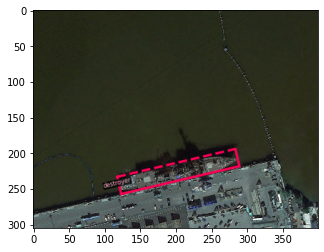

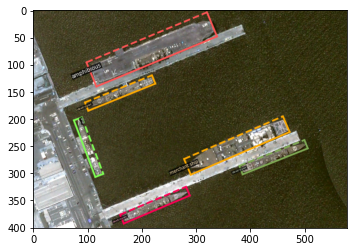

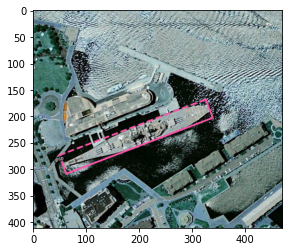

In [7]:
dataset_dicts = get_dataset("Train")
for d in random.sample(dataset_dicts, 3):
    img = cv2.imread(d["file_name"])
    visualizer = myVisualizer(img[:, :, ::-1], metadata=MetadataCatalog.get("Train"), scale=0.5)
    out = visualizer.draw_dataset_dict(d)
    plt.imshow(out.get_image()[:, :, ::-1])
    plt.show()


In [8]:
d

{'file_name': '/usr/workspace/zhong2/Research/FeedOpt/Questek/Data/HRSC2016/Train/AllImages/100001137.bmp',
 'image_id': 100001137,
 'height': 822,
 'width': 943,
 'annotations': [{'bbox': [388.0149,
    477.1577,
    590.9527,
    74.26126,
    20.900950326889106],
   'bbox_mode': <BoxMode.XYWHA_ABS: 4>,
   'category_id': 6}]}

## Setup configuration
Now we've got out data in a usable form,and some useful functions lets configure our tests. below are the options for training, 

In [9]:
dataset_train = 'Train'
dataset_test = 'Test'
res_dir = './output/'
# model_weights = '/usr/workspace/zhong2/Research/FeedOpt/Questek/Models/R-50.pkl'
# model_weights = '/usr/workspace/zhong2/Research/FeedOpt/Questek/Data/HRSC2016/output/model_final.pth'
model_weights = '/usr/workspace/zhong2/Research/FeedOpt/Questek/Results/HRSC2016/model_0004499.pth'

cfg = get_cfg()
cfg.OUTPUT_DIR = os.path.join(res_dir)

#cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
#cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")  # Let training initialize from model zoo
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml"))
cfg.MODEL.WEIGHTS = model_weights

cfg.DATASETS.TRAIN = ([dataset_train])
cfg.DATASETS.TEST = ([dataset_test])

cfg.SOLVER.IMS_PER_BATCH = 15 #can be up to  24 for a p100 (6 default)
cfg.SOLVER.CHECKPOINT_PERIOD = 1500
cfg.SOLVER.BASE_LR = 0.02
cfg.SOLVER.GAMMA = 0.5
cfg.SOLVER.STEPS = [1000, 2000, 4000, 8000, 12000]
cfg.SOLVER.MAX_ITER = 5000

cfg.MODEL.MASK_ON = False
cfg.MODEL.PROPOSAL_GENERATOR.NAME = "RRPN"
cfg.MODEL.RPN.HEAD_NAME = "StandardRPNHead"
cfg.MODEL.RPN.BBOX_REG_WEIGHTS = (10,10,5,5,1)
cfg.MODEL.ANCHOR_GENERATOR.NAME = "RotatedAnchorGenerator"
# cfg.MODEL.ANCHOR_GENERATOR.ANGLES = [[0,30,60,90,120,150]]
cfg.MODEL.ANCHOR_GENERATOR.ANGLES = [[-90,-60,-30,0,30,60,90]]
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.8 
cfg.MODEL.ROI_HEADS.NAME = "RROIHeads"
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 4   #this is far lower than usual.  
cfg.MODEL.ROI_HEADS.NUM_CLASSES = len(class_name_list)
cfg.MODEL.ROI_BOX_HEAD.POOLER_TYPE = "ROIAlignRotated"
cfg.MODEL.ROI_BOX_HEAD.BBOX_REG_WEIGHTS = (10,10,5,5,1)
cfg.MODEL.ROI_BOX_HEAD.NUM_CONV = 4
cfg.MODEL.ROI_MASK_HEAD.NUM_CONV = 8
cfg.MODEL.DEVICE = 'cpu'

# cfg.DATALOADER.NUM_WORKERS = 4
cfg.DATALOADER.FILTER_EMPTY_ANNOTATIONS = True 
cfg.DATALOADER.SAMPLER_TRAIN = "RepeatFactorTrainingSampler"
cfg.DATALOADER.REPEAT_THRESHOLD = 0.01
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)#lets just check our output dir exists
cfg.MODEL.BACKBONE.FREEZE_AT = 6



# Notes on how to implement:
# https://github.com/facebookresearch/detectron2/issues/21#issuecomment-595522318
# MODEL:
#   ANCHOR_GENERATOR:
#     NAME: RotatedAnchorGenerator
#     ANGLES: [[-90,-60,-30,0,30,60,90]]
#   PROPOSAL_GENERATOR:
#     NAME: RRPN
#   RPN:
#     BBOX_REG_WEIGHTS: (1,1,1,1,1)
#   ROI_BOX_HEAD:
#     POOLER_TYPE: ROIAlignRotated
#     BBOX_REG_WEIGHTS: (10,10,5,5,1)
#   ROI_HEADS:
#     NAME: RROIHeads

# print(cfg.OUTPUT_DIR)
# print(cfg.MODEL)


## Training
### Load tensorboard to view progress

In [ ]:
# Look at training curves in tensorboard:
%load_ext tensorboard
%tensorboard --logdir "$cfg.OUTPUT_DIR"

### Start training

In [ ]:
# cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")

trainer = MyTrainer(cfg) 
trainer.resume_or_load(resume=True)   # resume:https://detectron2.readthedocs.io/en/latest/modules/engine.html#detectron2.engine.defaults.DefaultTrainer.resume_or_load
trainer.train()

## Evaluation

The results produced about aren't as accurate as those performed outside of training. So let's rerun our evaluations. 

In [10]:
def my_convert_to_coco_dict(dataset_dicts, class_name_list):

    coco_images = []
    coco_annotations = []
    coco_categories = [{"id": index, "name": value, "supercategory": "empty"} for
                  index, value in enumerate(class_name_list)]

    for image_dict in dataset_dicts:
        coco_image = {
            "id": int(image_dict["image_id"]),
            "width": image_dict["width"],
            "height": image_dict["height"],
            "file_name": image_dict["file_name"],
        }
        coco_images.append(coco_image)

        for annotation in image_dict["annotations"]:
            coco_annotation = {}

            # COCO requirement: XYWH box format
            bbox = annotation["bbox"]
            bbox_mode = annotation["bbox_mode"]
            # Computing areas using bounding boxes
            bbox_xy = BoxMode.convert(bbox, bbox_mode, BoxMode.XYXY_ABS)
            area = Boxes([bbox_xy]).area()[0].item()

            # COCO requirement:
            #   linking annotations to images
            #   "id" field must start with 1
            coco_annotation["id"] = len(coco_annotations) + 1
            coco_annotation["image_id"] = coco_image["id"]
            coco_annotation["bbox"] = [round(float(x), 3) for x in bbox]
            coco_annotation["area"] = float(area)
            coco_annotation["iscrowd"] = 0
            coco_annotation["category_id"] = annotation["category_id"]

            coco_annotations.append(coco_annotation)

    info = {
        "date_created": str(datetime.datetime.now()),
        "description": "Automatically generated COCO json file for Detectron2.",
    }

    coco_dict = {
        "info": info,
        "images": coco_images,
        "annotations": coco_annotations,
        "categories": coco_categories,
        "licenses": None,
    }
    return coco_dict


def my_convert_to_coco_json(output_file, dataset_dicts, class_name_list):
    coco_dict = my_convert_to_coco_dict(dataset_dicts, class_name_list)

    PathManager.mkdirs(os.path.dirname(output_file))
    with PathManager.open(output_file, "w") as f:
        json.dump(coco_dict, f)

coco_json_path = os.path.join(dataset_path, "Test_coco_format.json")
my_convert_to_coco_json(coco_json_path, get_dataset("Test"), class_name_list)
register_coco_instances("Test_coco", {}, coco_json_path, "/")

In [11]:
# Bug in RotatedCOCOEvaluator where it gets passed img_ids
class MyRotatedCOCOEvaluator(RotatedCOCOEvaluator):
    def _eval_predictions(self, tasks, predictions, img_ids=None):
        super()._eval_predictions(tasks, predictions)

In [12]:
# Create coco evaluator, but use the default detectron2 data format for generation, make sure ids overlap
evaluator = MyRotatedCOCOEvaluator("Test_coco", cfg, False, output_dir=cfg.OUTPUT_DIR)
val_loader = build_detection_test_loader(cfg, "Test", mapper=mapper) 
outputs = inference_on_dataset(trainer.model, val_loader, evaluator)


WARNING [02/20 16:34:39 d2.evaluation.coco_evaluation]: COCO Evaluator instantiated using config, this is deprecated behavior. Please pass in explicit arguments instead.
[02/20 16:34:40 d2.data.build]: Distribution of instances among all 9 categories:
|   category    | #instances   |   category    | #instances   |  category  | #instances   |
|:-------------:|:-------------|:-------------:|:-------------|:----------:|:-------------|
|   destroyer   | 297          | merchant ship | 216          |  warcraft  | 64           |
| aircraft ca.. | 64           |  amphibious   | 110          | submarine  | 60           |
|     ship      | 257          |  Hovercraft   | 50           |  cruiser   | 110          |
|               |              |               |              |            |              |
|     total     | 1228         |               |              |            |              |
[02/20 16:34:40 d2.data.common]: Serializing 444 elements to byte tensors and concatenating them all ...

NameError: name 'trainer' is not defined

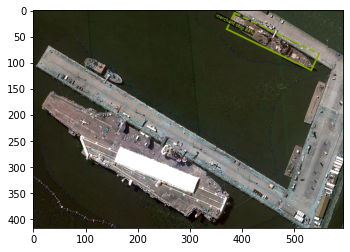

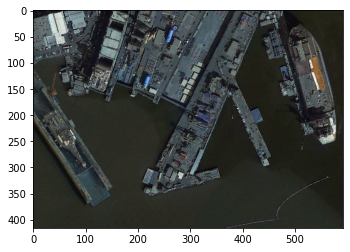

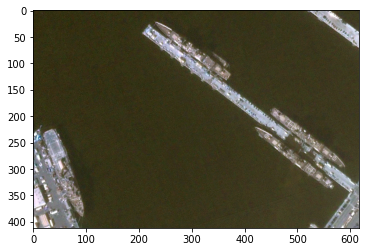

In [16]:
# cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")

# predictor = RotatedPredictor(cfg)
predictor = DefaultPredictor(cfg)

test_dict = get_dataset("Test")
for d in random.sample(test_dict, 3):
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)  # format is documented at https://detectron2.readthedocs.io/tutorials/models.html#model-output-format
    v = myVisualizer(im[:, :, ::-1],
                  metadata=MetadataCatalog.get("Test"), 
                  scale=0.5)
                  # instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels. This option is only available for segmentation models
    # )
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    plt.imshow(out.get_image()[:, :, ::-1])
    plt.show()


In [34]:
def get_file_record(file_id, dataset_path='/Users/zhong2/Desktop/Data/QuesTek/HRSC2016', set_folder="Train") :
    #open file xml
    xml_path = os.path.join(dataset_path, set_folder, 'Annotations', file_id+".xml")
    img_path = os.path.join(dataset_path, set_folder, 'AllImages', file_id+'.bmp')

    # check if Annotation exists and img file exists
    if not os.path.isfile(xml_path) or not os.path.isfile(img_path):
        return

    tree = X.parse(xml_path)
    root = tree.getroot()

    record = {}
    #store our file data
    record["file_name"] = img_path
    record["image_id"] = int(root.find("Img_FileName").text)
    record["height"] = int(root.find("Img_SizeHeight").text)
    record["width"] =  int(root.find("Img_SizeWidth").text)

    objs = []
    for anno in root.findall("HRSC_Objects/HRSC_Object"):
        x1=int(anno.findtext("box_xmin"))
        x2=int(anno.findtext("box_xmax"))
        y1=int(anno.findtext("box_ymin"))
        y2=int(anno.findtext("box_ymax"))
        a=-math.degrees(float(anno.findtext("mbox_ang")))
        cx=float(anno.findtext("mbox_cx"))
        cy=float(anno.findtext("mbox_cy"))
        w=float(anno.findtext("mbox_w"))
        h=float(anno.findtext("mbox_h"))
        print(float(anno.findtext("mbox_ang")), a)
        obj = {
            "bbox": [cx,cy,w,h,a],
            "bbox_mode": BoxMode.XYWHA_ABS,
            "category_id": class_id_dict[anno.find("Class_ID").text]
            }
        objs.append(obj)
    record["annotations"] = objs
    return record

a = get_file_record('100000001')
# DatasetCatalog.clear()
# MetadataCatalog.clear()
# for d in ["Train", "Test"]:
#     DatasetCatalog.register(d, lambda d=d: get_dataset(d))
#     MetadataCatalog.get(d).set(thing_classes=class_name_list)

-0.2144308 12.285979837613853
